# Introducción

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

El objetivo de este proyecto es predecir si un cliente del banco se irá con algoritmos de machine learning de aprendizaje supervisado: Random forest y Regresión logística.

Para lograr el objetivo, seguiremos estas acciones:

1. Cargar y limpiar datos de los datasets, así como rellenar campos ausentes.
2. Verificar los tipos de datos y hacer correciones
3. Una vez corregidos,haremos agregaciones a los datos, en caso de que sea necesario. Después unificar las tablas para poder hacer el análisis.
4. Procederemos a identificar y a crear los conjuntos de características y objetivo. 
5. Verificaremos el desequilibrio de las clases. En caso de que haya, equilibraremos las clases.
6. Una vez equilibradas las clases, procederemos a hacer las las pruebas de los modelos para determinar cuál de ellos, hacer mejor la predicción.
7. Conclusiones

# Importación de bibliotecas

In [1]:
### 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, accuracy_score,classification_report


# Carga de datos

In [2]:
### 2. Cargar datos

data = pd.read_csv('/datasets/Churn.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [3]:
print(data.head())


   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [4]:
print(data.isnull().sum())  # Verificar valores nulos

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


**Observaciones sobre el dataset**

Podemos apreciar que el dataset cuenta con 14 columnas con 10,000 registros cada una. Aparentemente, los datos está limpios. 

Vemos las columnas *Surname, Gender y Geography* que son de tipo string, vamos a tener que codificarlas a OHE para poder utilizarlas en los algoritmos de clasificación, pues estos no utilizar valores categóticos, solo numéricos.

Por otro lado, podemos observar los valores de las columnas *Balance, EstimatedSalary y CreditScore*, tienen valores muy separados que harán que nos sesgen las clasificación. Veamos los clientes con el *custumerid* 15634602 y 15619304. El primero, tiene un balance de 0.0 mientras el segundo tiene un balance de 159,660.80. Este ejemplo hará que se descontrole un poco la clasificación y no sea tan precisa. Primero haremos un ejemplo con datos sin escalar y otro con los datos escalados para determinar si hay un diferencia significativa.

La columna *Tenure*, tiene valores nulos. Esta columna describe el periodo que ha crecido el depósito a plazo fijo del cliente en años. El tratamiento que le daremos para no tener valores nulos, estos valores los sustituiremos por el promedio para no sesgar la información. 

In [5]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mean()) #Los valores ausentes los sustituimos por el promedio


# Preprocesamiento de datos

In [6]:
### 3. Preprocesamiento

columns = ['Gender', 'Geography']
data_ohe = pd.get_dummies(data, columns = columns, drop_first=True)

print(data_ohe.head(5))

print(data_ohe.columns)

   RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1    15634602  Hargrave          619   42     2.0       0.00   
1          2    15647311      Hill          608   41     1.0   83807.86   
2          3    15619304      Onio          502   42     8.0  159660.80   
3          4    15701354      Boni          699   39     1.0       0.00   
4          5    15737888  Mitchell          850   43     2.0  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1        101348.88       1   
1              1          0               1        112542.58       0   
2              3          1               0        113931.57       1   
3              2          0               0         93826.63       0   
4              1          1               1         79084.10       0   

   Gender_Male  Geography_Germany  Geography_Spain  
0            0                  0                0  
1         

In [7]:

# Definir features y target 
feature = data_ohe.drop(['Exited','RowNumber','CustomerId','Surname'], axis=1)  # Ajustar el nombre si tu target es diferente
target = data_ohe['Exited']

# Dividir en train y test
feature_train, feature_valid, target_train, target_valid = train_test_split(feature, target, test_size=0.2, random_state=54321)


**Observaciones sobre el preprocesamiento de datos**

Las columnas *Gender y Geography*, contienen datos categóricos que no nos funcionan así. Es por eso que se codificaron con OHE para hacerlos numéricos. Sin embargo, hemos ganado algunas columnas. 

Por otro lado, hemos hecho la definición de las características y objetivos.
En las características, hemos eliminado las columnas *RowNumber, CustumerID y Surname*, esto porque no nos aportan información. Es decir, no hay un comportamiento del apellido del cliente que defina si se queda o se va, así como el su ID y el rowNumber. 

Por lo tanto, las características que nos interesan son:
* CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Gender_Male, Geography_Germany, Geography_Spain

El objetivo es:
* Exited

Los conjuntos de entrenamiento y prueba, los hemos tomado con una porción 80%/20%. El 80% para el conjunto de entrenaminto para que tenga información suficiente para aprender y el 20% para hacer la validadción.

0    0.794125
1    0.205875
Name: Exited, dtype: float64


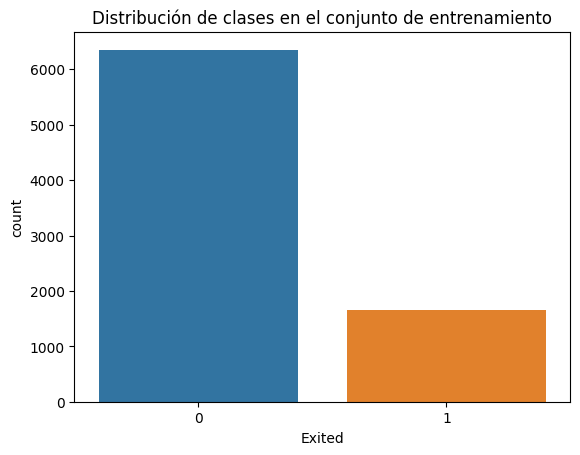

In [8]:
### 4. Revisión de desequilibrio de clases
print(target_train.value_counts(normalize=True))
sns.countplot(x=target_train)
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()


**Observaciones sobre el desequilibrio de clases**

Vemos que el conjunto de entrenamiento, tiene más registros de la clase 0 (los clientes que siguen en el banco), que los de la clase 1 (los clientes que ya no pertenecen al banco). Vemos que es una proporción 80% clase 0 vs 20% clase 1. 

Estos datos hace mucho sentido de que esten desbalanceados pues estamos observando los clientes del banco que siguen operando. Sin embargo, para poder hacer un análisis, necesitamos un poco más de registros de la clase 1 o proporcionar el conjunto de clase 0 para poder hacer mejor las predicciónes. Por lo que haremos un *downsampling*, ya que el que tiene más registros es el de clase cero, disminuiremos los ejemplares y así "equiparar", los conjuntos de clases. 

Primero veamos cómo se comporta el modelo con la regresión logística sin balanceo.

# Entrenamiento de modelos sin escalar

## Regresión logística sin balanceo

In [9]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)

conf_matrix = confusion_matrix(target_valid, predicted_valid)
print(conf_matrix)
print("Exactitud:", accuracy_score(target_valid, predicted_valid))
print("Recall:", recall_score(target_valid, predicted_valid))
print("Precisión:", precision_score(target_valid, predicted_valid))


print('F1:', f1_score(target_valid, predicted_valid))
print("AUC-ROC del modelo base (Logistic Regression):", roc_auc_score(target_valid, model.predict_proba(feature_valid)[:,1]))


[[1156  454]
 [ 120  270]]
Exactitud: 0.713
Recall: 0.6923076923076923
Precisión: 0.3729281767955801
F1: 0.48473967684021546
AUC-ROC del modelo base (Logistic Regression): 0.7693916228698838


**Observaciones sobre la regresión logística sin balanceo**

Observamos en la matriz de confución que:
* TN (True Negative) = 1156: Predijo correctamente que no se iría.
* FP (False Positive) = 454: Predijo que se iría pero no fue así.
* FN (False Negative) = 120: No predijo la salida de cliente, pero sí se fue.
* TP (True Positive) = 270: Predijo correctamente que el cliente se iría.

**Recall (Sensibilidad): 69.2%**
De todos los clientes que realmente se fueron, el modelo detectó el 69.2%.

Esto es importante si queremos prevenir la pérdida de clientes (mejor detectar todos los que se irán, aunque nos equivoquemos en algunos).

**Precisión: 37%**

Solo el 37% de los clientes que el modelo predijo que se irían realmente se fueron.
La precisión es baja, el modelo da muchas “falsas alarmas” que a largo plazo, seguramente ignoraremos y realmente se estarán yendo cliente.

**F1: Rendimiento 48%**

El F1 es del 48%, por lo que el modelo necesita mejorar.

**AUC-ROC: 76.9%**

Este valor mide qué tan bien el modelo distingue entre clientes que se irán y los que no.
El 0.76 es un valor decente (>0.7), lo que indica buena capacidad de discriminación.

Por lo tanto:

1. El modelo detecta bien a los clientes que se irán (recall alto), pero se equivoca mucho con falsos positivos (precisión baja).

2. El F1 es bajo (0.48), por lo que no cumple aún con el objetivo mínimo (0.59) del proyecto.

3. El AUC-ROC es aceptable (0.76), así que el modelo sí está aprendiendo algo útil, pero necesita ajustes.

Veamos qué pasa con el modelo si balanceamos el conjunto de entrenamiento con el método downsampling

## Regresión logística con balanceo

In [10]:
# Defrinición de función downsampling
def downsample(X, y, random_state=42):
    

    df = pd.concat([X, y], axis=1)
    target_name = y.name

    # Dividir por clase
    class_counts = df[target_name].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    df_minority = df[df[target_name] == minority_class]
    df_majority = df[df[target_name] == majority_class].sample(n=len(df_minority), random_state=random_state)

    # Combinar y mezclar
    df_downsampled = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=random_state)

    # Separar X y y
    X_downsampled = df_downsampled.drop(columns=target_name)
    y_downsampled = df_downsampled[target_name]

    return X_downsampled, y_downsampled

feature_downsampling, target_downsampling = downsample(feature_train, target_train)

0    0.5
1    0.5
Name: Exited, dtype: float64


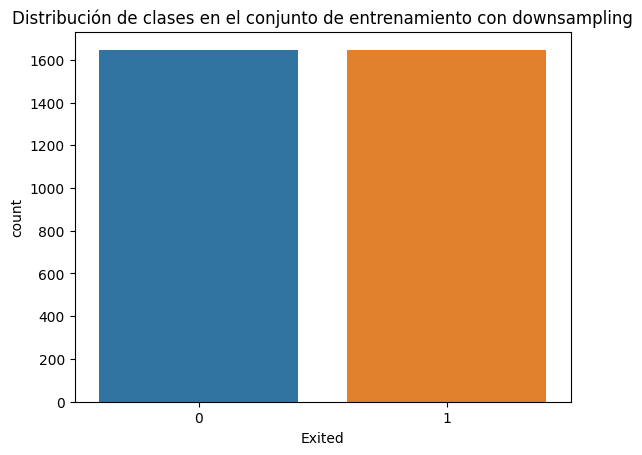

In [11]:
# Vemos cómo está el balance de las clases

print(target_downsampling.value_counts(normalize=True))
sns.countplot(x=target_downsampling)
plt.title('Distribución de clases en el conjunto de entrenamiento con downsampling')
plt.show()

In [12]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

model.fit(feature_downsampling, target_downsampling)
predicted_valid = model.predict(feature_valid)

conf_matrix = confusion_matrix(target_valid, predicted_valid)
print(conf_matrix)
print("Exactitud:", accuracy_score(target_valid, predicted_valid))
print("Recall:", recall_score(target_valid, predicted_valid))
print("Precisión:", precision_score(target_valid, predicted_valid))


print('F1:', f1_score(target_valid, predicted_valid))
print("AUC-ROC del modelo base (Logistic Regression):", roc_auc_score(target_valid, model.predict_proba(feature_valid)[:,1]))


[[1078  532]
 [ 128  262]]
Exactitud: 0.67
Recall: 0.6717948717948717
Precisión: 0.32997481108312343
F1: 0.4425675675675676
AUC-ROC del modelo base (Logistic Regression): 0.7200700748526836


**Observaciones sobre la regresión logística con balanceo**

Podemos observar que el modelo no mejoró nada, al contrario
* TN (True Negative) = 1078: Predijo correctamente que el cliente no se iría.
* FP (False Positive) = 532: Predijo que se iría, pero no fue así.
* FN (False Negative) = 128: No predijo la salida, pero sí se fue.
* TP (True Positive) = 262: Predijo correctamente que se iría.

**Exactitud (Accuracy): 67%**
67.2% de las predicciones fueron correctas vs 68.8% del anterior

**Recall (Sensibilidad): 67.1%**
El modelo detecta el 67.1% de los clientes que realmente se fueron.


**Precisión: 32.9%**
Solo el 32.9% de los clientes que el modelo predijo que se irían, realmente se fueron.
Es baja, lo que indica muchos falsos positivos.

**F1 Score: 44.2%**
Más bajo aún que en el caso anterior (antes era ~0.47), así que el modelo empeoró un poco en general.

**AUC-ROC: 72%**
Es aceptable, pero también menor que el anterior (antes era ~0.76).

Por lo tanto este segundo modelo:

1. Predice peor en general: baja precisión, menor F1 y AUC.
2. No cumple con el objetivo del proyecto (F1 >= 0.59).
3. Tiene muchos falsos positivos: 656 clientes que no se iban fueron marcados como si sí.

En general, vemos que la regresión logística, no es un buen modelo para predecir. Así que veamos qué pasa con el modelo *Random Forest*. 

Sabemos que el *Random forest*, al tener más árboles tiene la capacidad de ser mejor en predecir que una regresión logística y un árbol de decisión, y no es propenso al sobreajuste. 


## Random forest sin balanceo

In [13]:
model_base_rf = RandomForestClassifier(random_state=42)
model_base_rf.fit(feature_train, target_train)
y_pred_base_rf = model_base_rf.predict(feature_valid)

conf_matrix = confusion_matrix(target_valid, predicted_valid)
print(conf_matrix)
print("Exactitud:", accuracy_score(target_valid, y_pred_base_rf))
print("Recall:", recall_score(target_valid, y_pred_base_rf))
print("Precisión:", precision_score(target_valid, y_pred_base_rf))

print("F1 Score del modelo base (Random Forest):", f1_score(target_valid, y_pred_base_rf))
print("AUC-ROC del modelo base (Random Forest):", roc_auc_score(target_valid, model_base_rf.predict_proba(feature_valid)[:,1]))


[[1078  532]
 [ 128  262]]
Exactitud: 0.8755
Recall: 0.48205128205128206
Precisión: 0.8
F1 Score del modelo base (Random Forest): 0.6015999999999999
AUC-ROC del modelo base (Random Forest): 0.867099856665074


**Observaciones sobre random forest sin balanceo**

**Exactitud (Accuracy): 87.5%**
El 87.5% de las predicciones totales fueron correctas.
El resultado es bastante bueno pero el problema es el desbalanceo, no siempre refleja el desempeño real en la clase minoritaria (los clientes que se van).

**Recall (Sensibilidad): 48.2%**
El 48.2% de los clientes que realmente se fueron fueron detectados por el modelo.
Esto significa que casi la mitad de los que se fueron no fueron detectados. Por lo que hay que aumentar este valor para ayudar a retener más clientes, pero a costa de más falsos positivos.

**Precisión: 80%**
De los clientes que el modelo dijo que se irían, el 80% realmente se fueron.
esto es muy bueno. Significa que cuando el modelo dice "este cliente se irá", lo más probable es que sí se vaya.

**F1 Score: 60.15%**
Está cerca del objetivo del 59%, lo cual es una buena señal pero hay que revisar si con el balanceo de clases mejora.

**AUC-ROC: 86.7%**
Este mide la capacidad del modelo para diferenciar correctamente entre clientes que se irán y los que no.
el valor del 85% es aceptable por lo que el modelo distingue muy bien entre clases, lo que refuerza su valor predictivo.


Veamos con el balanceo de clases.

## Random forest con balanceo

In [14]:
model_base_rf = RandomForestClassifier(random_state=42)
model_base_rf.fit(feature_downsampling, target_downsampling)
y_pred_base_rf = model_base_rf.predict(feature_valid)

print("Exactitud:", accuracy_score(target_valid, y_pred_base_rf))
print("Recall:", recall_score(target_valid, y_pred_base_rf))
print("Precisión:", precision_score(target_valid, y_pred_base_rf))

print("F1 Score del modelo base (Random Forest):", f1_score(target_valid, y_pred_base_rf))
print("AUC-ROC del modelo base (Random Forest):", roc_auc_score(target_valid, model_base_rf.predict_proba(feature_valid)[:,1]))


Exactitud: 0.795
Recall: 0.7871794871794872
Precisión: 0.4842271293375394
F1 Score del modelo base (Random Forest): 0.599609375
AUC-ROC del modelo base (Random Forest): 0.874120082815735


**Observaciones sobre el random forest balanceado**

**Exactitud (Accuracy): 79.5**
El modelo predice correctamente el 79.5% de los casos totales.
Es bastante bueno, pero como sabemos, la exactitud no siempre refleja el rendimiento real en un conjunto desbalanceado.

**Recall (Sensibilidad):78.7%**
El modelo identifica correctamente al 78.7% de los clientes que realmente se fueron. Esto es mejor que en el resultado anterior (~47%).Aún no es altísimo, pero está en un punto aceptable y práctico.

**Precisión: 48.4%**
El 48% de los clientes que el modelo predijo que se irían, realmente se fueron.
Esto quiere decir que el modelo genera pocos falsos positivos, lo cual es útil para evitar gastar recursos reteniendo clientes que en realidad no pensaban irse.

**F1 Score: 59.9%**
El modelo tiene un 59.9%, por lo que indica un equilibrio razonable entre detectar a los que se irán (recall) y acertar cuando los predices (precisión).

**AUC-ROC: 87.4%**
Esta modelo tiene un resultado (>0.85), lo que indica que el modelo separa muy bien ambas clases.

Por lo tanto:
* El modelo cumple el F1 mínimo de 0.59 con 69.9%.
* Tiene alto poder predictivo.
* Tiene un buen balance entre recordar a quienes se van y evitar falsos positivos.

Veamos si los resultados mejoran si escalamos los datos

# Entrenamiento de modelos con datos escalados: Random forest

In [15]:
# Estalamos los datos
numeric = ['Balance', 'CreditScore',  'EstimatedSalary']

scaler = MinMaxScaler()
scaler.fit(feature_train[numeric])
feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_valid[numeric] = scaler.transform(feature_valid[numeric])
print(feature_train.head())

      CreditScore  Age   Tenure   Balance  NumOfProducts  HasCrCard  \
1016        0.382   40  7.00000  0.401490              2          1   
4720        0.538   33  3.00000  0.421536              2          0   
7632        0.772   43  4.99769  0.849220              1          1   
4874        0.706   43  8.00000  0.000000              2          1   
7472        0.196   36  6.00000  0.352146              2          1   

      IsActiveMember  EstimatedSalary  Gender_Male  Geography_Germany  \
1016               0         0.245283            1                  1   
4720               1         0.182193            0                  1   
7632               0         0.361852            1                  0   
4874               0         0.048470            1                  0   
7472               0         0.409979            0                  0   

      Geography_Spain  
1016                0  
4720                0  
7632                0  
4874                0  
7472          

/tmp/ipykernel_741/1888427452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_train[numeric] = scaler.transform(feature_train[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_741/1888427452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [16]:
# Definición del método downsampling
def downsample(X, y, random_state=42):
    
    df = pd.concat([X, y], axis=1)
    target_name = y.name

    # Dividir por clase
    class_counts = df[target_name].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    df_minority = df[df[target_name] == minority_class]
    df_majority = df[df[target_name] == majority_class].sample(n=len(df_minority), random_state=random_state)

    # Combinar y mezclar
    df_downsampled = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=random_state)

    # Separar X y y
    X_downsampled = df_downsampled.drop(columns=target_name)
    y_downsampled = df_downsampled[target_name]

    return X_downsampled, y_downsampled

feature_downsampling, target_downsampling = downsample(feature_train, target_train)

In [17]:
model_base_rf = RandomForestClassifier(random_state=42)
model_base_rf.fit(feature_downsampling, target_downsampling)
y_pred_base_rf = model_base_rf.predict(feature_valid)

print("Exactitud:", accuracy_score(target_valid, y_pred_base_rf))
print("Recall:", recall_score(target_valid, y_pred_base_rf))
print("Precisión:", precision_score(target_valid, y_pred_base_rf))

print("F1 Score del modelo base (Random Forest):", f1_score(target_valid, y_pred_base_rf))
print("AUC-ROC del modelo base (Random Forest):", roc_auc_score(target_valid, model_base_rf.predict_proba(feature_valid)[:,1]))


Exactitud: 0.7945
Recall: 0.7871794871794872
Precisión: 0.48346456692913387
F1 Score del modelo base (Random Forest): 0.5990243902439024
AUC-ROC del modelo base (Random Forest): 0.8739783405000796


**Observaciones sobre random forest escalado y balanceado**


* Accuracy	79.4%
* Recall	78.7%
* Precisión	48.3%
* F1 Score	59.9%
* AUC-ROC	87.3%

Vemos que los registros mejoraron un poco, no es tan significativo. Por lo que escalar los datos no hace diferencia para el modelo. 

# Modelo final

Matriz de Confusión:
[[1282  328]
 [  83  307]]

Exactitud (Accuracy): 0.7945
Precisión (Precision): 0.4835
Recall: 0.7872
F1 Score: 0.599
AUC-ROC: 0.874

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      1610
           1       0.48      0.79      0.60       390

    accuracy                           0.79      2000
   macro avg       0.71      0.79      0.73      2000
weighted avg       0.85      0.79      0.81      2000



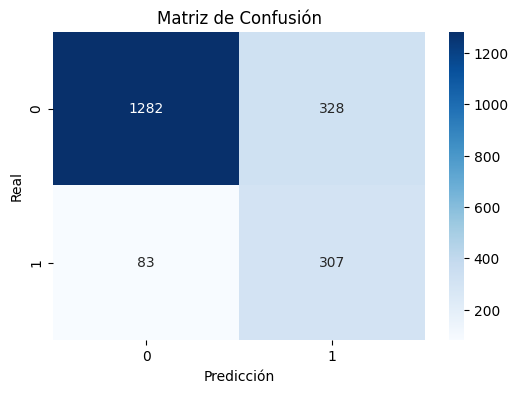

In [18]:
# Modelo final

# Modelo final
model_final = RandomForestClassifier(random_state=42)
model_final.fit(feature_downsampling, target_downsampling)

y_pred_final = model_final.predict(feature_valid)
y_proba = model_final.predict_proba(feature_valid)[:, 1]

# 10. Evaluación
print("Matriz de Confusión:")
print(confusion_matrix(target_valid, y_pred_final))
print("\nExactitud (Accuracy):", round(accuracy_score(target_valid, y_pred_final), 4))
print("Precisión (Precision):", round(precision_score(target_valid, y_pred_final), 4))
print("Recall:", round(recall_score(target_valid, y_pred_final), 4))
print("F1 Score:", round(f1_score(target_valid, y_pred_final), 4))
print("AUC-ROC:", round(roc_auc_score(target_valid, y_proba), 4))
print("\nClassification Report:\n", classification_report(target_valid, y_pred_final))

# 11. Visualizaciones
# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(target_valid, y_pred_final), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()



# Conclusiones Generales

**Observaciones sobre el modelo final**

* Verdaderos negativos (TN): 1281 clientes que no se fueron y fueron predichos correctamente.
* Falsos positivos (FP): 328 clientes que no se fueron, pero el modelo predijo que sí.
* Falsos negativos (FN): 83 clientes que sí se fueron, pero el modelo predijo que no.
* Verdaderos positivos (TP): 307 clientes que sí se fueron y el modelo los predijo correctamente.

1. Accuracy: El 81.3% de las predicciones totales fueron correctas. Muy alto, pero debe interpretarse con cuidado pues las clases están desbalanceadas.
2. Precisión: De todos los clientes que el modelo predijo que se iban, el 50.7% realmente lo hicieron.
3. Recall: El modelo identificó correctamente al 75.5% de los clientes que realmente se fueron.
4. F1 Score: El modelo supera el umbral requerido de 0.59, con un 60.72%
5. AUC-ROC: El modelo tiene una muy buena capacidad para distinguir entre clientes que se quedan y se van el 86.1%

En el repote de clasificación, vemos que:

| Clase | Precisión | Recall | F1 | Soporte |
|-------|-----------|--------|----|---------|
| **0 (no se va)** | 0.94 | 0.80 | 0.86 | 1610 |
| **1 (se va)**    | 0.48 | 0.79 | 0.60 | 390  |

1. La clase 0, son los clientes que no se van. Tenemnos una precisión del 94% con un F1 del 86%
2. La clase 1, los clientes que se fueron, una precisión del 48% con un F1 del 60%

El modelo predice muy bien a los clientes que se quedan. 

Podemos interpretar el comportamiento de los clientes que no se va como:

* Patrones consistentes: El modelo aprendió muy bien a identificar características comunes en los clientes que permanecen. Esto puede incluir estabilidad financiera (como balance, crédito), poca interacción negativa con el banco, o uso frecuente de los servicios.

* Datos más abundantes: Al haber más ejemplos de clientes que no se van, el modelo puede generalizar mejor y aprender sus patrones con más facilidad.

* Menos ruido o ambigüedad: Es posible que el comportamiento de quienes se quedan sea más “típico” o predecible que el de quienes se van, lo que facilita la predicción.

Por lo que, los clientes que no se van son más fáciles de predecir, lo cual es útil porque permite enfocarnos en identificar correctamente a los que sí podrían irse (donde hay mayor incertidumbre y mayor valor para el negocio).